## Gamma-ray fluxes for DM processes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import astropy.units as u
from astropy.io import fits

In [2]:
plt.style.use('astroph')

## Load spectras

In [3]:
spectras = pd.read_pickle('spectras/at-production-gammas.pkl')

In [4]:
spectras.tail()

,$m_{DM}$,$\log_{10} x$,$e^L$,$e^R$,$e$,$\mu^L$,$\mu^R$,$\mu$,$\tau^L$,$\tau^R$,...,$Z$,$g\bar{g}$,$\gamma$,$h$,$\nu_e$,$\nu_{\mu}$,$\nu_{\tau}$,$VV \rightarrow 4e$,$VV \rightarrow 4\mu$,$VV \rightarrow 4\tau$
11093,100000.0,-0.20,0.120376,0.164452,0.142414,0.118679,0.162191,0.140435,0.250219,0.343664,...,0.017353,0.034521,0.006268,0.018649,0.036341,0.035359,0.062713,0.049568,0.007253,0.016084
11094,100000.0,-0.15,0.114321,0.156519,0.135420,0.112061,0.153479,0.132770,0.180252,0.247822,...,0.011076,0.020960,0.005056,0.014080,0.032615,0.031520,0.044223,0.037050,0.004981,0.006714
11095,100000.0,-0.10,0.108509,0.148947,0.128728,0.105200,0.144449,0.124824,0.129938,0.178762,...,0.006866,0.013063,0.041196,0.011203,0.028697,0.027460,0.031130,0.025530,0.003149,0.002627
11096,100000.0,-0.05,0.102214,0.140988,0.121601,0.097452,0.134443,0.115948,0.098153,0.135501,...,0.003653,0.008542,2.149326,0.009287,0.022050,0.020845,0.020311,0.015730,0.001788,0.000973
11097,100000.0,0.00,0.097123,0.135170,0.116147,0.091384,0.127185,0.109285,0.084001,0.116918,...,0.001291,0.006717,53.850927,0.008043,0.011482,0.010782,0.009848,0.008371,0.000889,0.000348


In [5]:
class SpectraQuery:

    def __init__(self, fluxes_table, mass_col='$m_{DM}$'):
        self.fluxes_table = fluxes_table
        self.mass_col = mass_col
        self.masses = fluxes_table[mass_col].unique()
        
    def get_allowed_masses(self):
        return self.masses
    
    def spectra_at_channel(self, mass, channel='$e$', log_x=r'$\log_{10} x$'):
        fluxes = self.fluxes_table.loc[self.fluxes_table[self.mass_col] == mass]
        if fluxes.shape[0] == 0:
            return 'Not a valid DM component mass.'
        energies = (10.0)**fluxes[log_x]*mass
        channel_flux = fluxes[channel]/(energies*np.log(10.0))
        return energies, channel_flux


In [6]:
query = SpectraQuery(spectras)

In [51]:
query.get_allowed_masses()

array([5.0e+00, 6.0e+00, 8.0e+00, 1.0e+01, 1.5e+01, 2.0e+01, 2.5e+01,
       3.0e+01, 4.0e+01, 5.0e+01, 6.0e+01, 7.0e+01, 8.0e+01, 9.0e+01,
       1.0e+02, 1.1e+02, 1.2e+02, 1.3e+02, 1.4e+02, 1.5e+02, 1.6e+02,
       1.8e+02, 2.0e+02, 2.2e+02, 2.4e+02, 2.6e+02, 2.8e+02, 3.0e+02,
       3.3e+02, 3.6e+02, 4.0e+02, 4.5e+02, 5.0e+02, 5.5e+02, 6.0e+02,
       6.5e+02, 7.0e+02, 7.5e+02, 8.0e+02, 9.0e+02, 1.0e+03, 1.1e+03,
       1.2e+03, 1.3e+03, 1.5e+03, 1.7e+03, 2.0e+03, 2.5e+03, 3.0e+03,
       4.0e+03, 5.0e+03, 6.0e+03, 7.0e+03, 8.0e+03, 9.0e+03, 1.0e+04,
       1.2e+04, 1.5e+04, 2.0e+04, 3.0e+04, 5.0e+04, 1.0e+05])

## Load $J$-factor maps

In [7]:
def load_fits(path):
    with fits.open(path) as hdul:
        data = hdul[0].data
    return data

In [8]:
nfw_annih = load_fits('maps/nfw_annih.fits')
einasto_annih = load_fits('maps/einasto_annih.fits')

*Aditional maps*: Apertures and $\theta$

In [9]:
apertures = load_fits('maps/apertures.fits')
thetas = load_fits('maps/thetas.fits')

## Calculate $\bar{J}$ for GC

In [10]:
def j_bar(data, apertures, mask):
    return data[mask].sum()/apertures[mask].sum()

* $\theta < 0.1º$

In [11]:
theta1 = 0.1*np.pi/180.0
mask1 = (thetas <= theta1)

In [12]:
jbar01 = j_bar(nfw_annih, apertures, mask1)

In [13]:
total_aperture = apertures[mask1].sum().sum()

In [14]:
jbar01

11415.475913769818

In [15]:
total_aperture

9.630780651895866e-06

## Channels

In [52]:
masses = [10, 50, 100, 1000]

In [53]:
colors = ['k', 'crimson',  'royalblue', 'limegreen']

**Units**

* Spectra: 1/GeV
* $m_{DM}$: GeV.
* $\rho_{\odot}$: GeV/cm³.
* $r_{\odot}$: kpc.
* $\bar J$: dimensionless.
* $\langle \sigma v \rangle$: cm³/s

In [54]:
def calculate_flux(spectra, dm_mass, j_bar, aperture,
                   sigmav=3e-26*u.cm**3/u.s,
                   r_sun=(8.33*u.kpc).to(u.cm)*u.cm,
                   rho_sun=0.3*u.GeV/u.cm**3, 
                   unit=u.erg/u.cm**2/u.s):
    flux = r_sun/(8*np.pi) * (rho_sun/dm_mass)**2 * j_bar * aperture * sigmav * spectra
    return flux*unit

### 1. $b \bar b $

In [57]:
colors

['k', 'crimson', 'royalblue', 'limegreen']

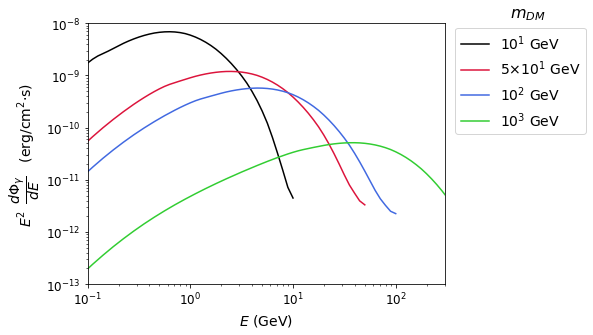

In [87]:
for mass, color in zip(masses, colors):
    # Energy is on GeV
    print()
    energy, spectra = query.spectra_at_channel(mass, channel=r'$b\bar{b}$')
    flux = calculate_flux(spectra, mass, j_bar=jbar01, aperture=total_aperture)
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    plt.plot(energy, (energy**2 * flux), '-', color=color, 
             label='$%s$ GeV'%f._formatSciNotation('%1.10e'%mass))
ax = plt.gca()
ax.set_xlabel("$E$ (GeV)")
ax.set_ylabel(r"$E^2 \,\,\, \dfrac{d\Phi_{\gamma}}{dE}$ $\,\,$ (erg/cm$^2$$\cdot$s)")
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.1, 300)
plt.ylim(1e-13, 1e-8)
plt.text(x=1.3e3, y=1.3e-8, s='$m_{DM}$', fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.01))
plt.savefig('../figures/fluxes_bbar.pdf', bbox_inches='tight')
plt.show()

#### 2. $t \bar t$

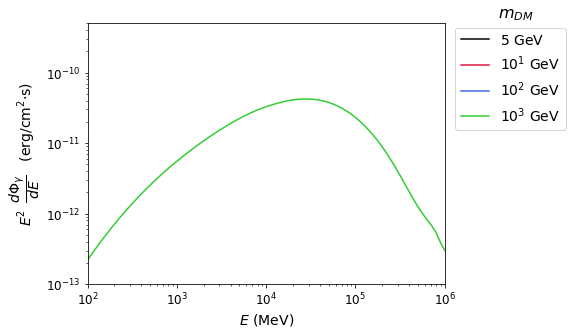

In [46]:
for mass, color in zip(masses, colors):
    energy, spectra = query.spectra_at_channel(mass, channel=r'$t\bar{t}$')
    flux = calculate_flux(spectra, mass, j_bar=jbar01, aperture=total_aperture)
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    plt.plot(energy*1e3, energy**2 * flux, '-', color=color, 
             label='$%s$ GeV'%f._formatSciNotation('%1.10e'%mass))
ax = plt.gca()
ax.set_xlabel("$E$ (MeV)")
ax.set_ylabel(r"$E^2 \,\,\, \dfrac{d\Phi_{\gamma}}{dE}$ $\,\,$ (erg/cm$^2$$\cdot$s)")
plt.xscale('log')
plt.yscale('log')
plt.text(x=0.4e7, y=6e-10, s='$m_{DM}$', fontsize=16)
plt.ylim(1e-13, 5e-10)
plt.xlim(1e2, 1e6)
plt.legend(bbox_to_anchor=(1.01, 1.01))
plt.savefig('../figures/fluxes_ttbar.pdf', bbox_inches='tight')
plt.show()

### 3. $\tau^{+} \tau^{-}$

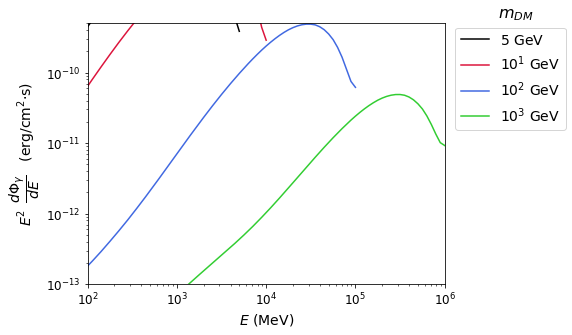

In [47]:
for mass, color in zip(masses, colors):
    energy, spectra = query.spectra_at_channel(mass, channel=r'$\tau$')
    flux = calculate_flux(spectra, mass, j_bar=jbar01, aperture=total_aperture)
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    plt.plot(energy*1e3, energy**2 * flux, '-', color=color, 
             label='$%s$ GeV'%f._formatSciNotation('%1.10e'%mass))
ax = plt.gca()
ax.set_xlabel("$E$ (MeV)")
ax.set_ylabel(r"$E^2 \,\,\, \dfrac{d\Phi_{\gamma}}{dE}$ $\,\,$ (erg/cm$^2$$\cdot$s)")
plt.xscale('log')
plt.yscale('log')
plt.text(x=0.4e7, y=6e-10, s='$m_{DM}$', fontsize=16)
plt.ylim(1e-13, 5e-10)
plt.xlim(1e2, 1e6)
plt.legend(bbox_to_anchor=(1.01, 1.01))
plt.savefig('../figures/fluxes_tau.pdf', bbox_inches='tight')
plt.show()

### 4. $W^{+} W^{-}$

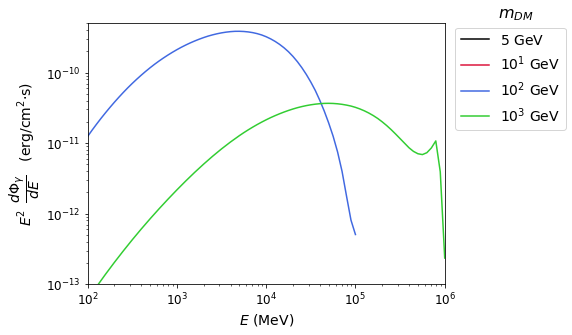

In [48]:
for mass, color in zip(masses, colors):
    energy, spectra = query.spectra_at_channel(mass, channel='$W$')
    flux = calculate_flux(spectra, mass, j_bar=jbar01, aperture=total_aperture)
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    plt.plot(energy*1e3, energy**2 * flux, '-', color=color, 
             label='$%s$ GeV'%f._formatSciNotation('%1.10e'%mass))
ax = plt.gca()
ax.set_xlabel("$E$ (MeV)")
ax.set_ylabel(r"$E^2 \,\,\, \dfrac{d\Phi_{\gamma}}{dE}$ $\,\,$ (erg/cm$^2$$\cdot$s)")
plt.xscale('log')
plt.yscale('log')
plt.text(x=0.4e7, y=6e-10, s='$m_{DM}$', fontsize=16)
plt.ylim(1e-13, 5e-10)
plt.xlim(1e2, 1e6)
plt.legend(bbox_to_anchor=(1.01, 1.01))
plt.savefig('../figures/fluxes_w.pdf', bbox_inches='tight')
plt.show()

## Comparing with LAT sensitivity

In [20]:
columns = ['$E_{min}$', '$E_{max}$', "$E^2 \dfrac{d\Phi}{dE}$"]

In [21]:
data = np.loadtxt('lat-dif-sensitivity/lat_dif_sensitivity.txt', comments='#')[:, :3]

In [22]:
emin, emax, energy_flux = data.T

In [23]:
pd.DataFrame(data, columns=columns).head()

,$E_{min}$,$E_{max}$,$E^2 \dfrac{d\Phi}{dE}$
0,31.622777,56.234133,1.900070e-11
1,56.234133,100.000000,1.549856e-11
2,100.000000,177.827941,1.302078e-11
3,177.827941,316.227766,1.149279e-11
4,316.227766,562.341325,9.351305e-12


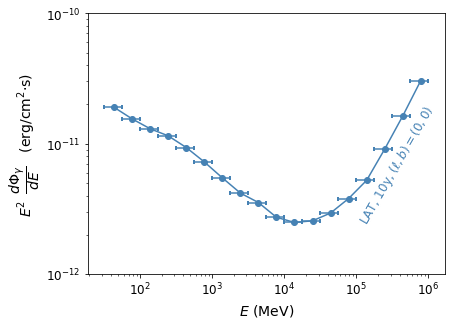

In [24]:
plt.errorbar(x=(emax+emin)/2, y=energy_flux, xerr=(emax-emin)/2, fmt='o-', markersize=6,
            color='steelblue', capsize=2, capthick=2)
plt.xscale('log', nonposx='mask')
plt.yscale('log')
plt.ylim(1e-12, 1e-10)
ax = plt.gca()
ax.set_xlabel("$E$ (MeV)")
ax.set_ylabel(r"$E^2 \,\,\, \dfrac{d\Phi_{\gamma}}{dE}$ $\,\,$ (erg/cm$^2$$\cdot$s)")
plt.text(x=1e5, y=0.25e-11, s='LAT, 10y, $(\ell, b) = (0, 0)$',
         fontsize=12, color='steelblue', rotation=60)
plt.savefig('../figures/lat_diff_sens.pdf', bbox_inches='tight')
plt.show()

## Comparing sensitivity with fluxes

In [25]:
channels = [r'$b\bar{b}$', r'$t\bar{t}$', r'$\tau$', '$W$']

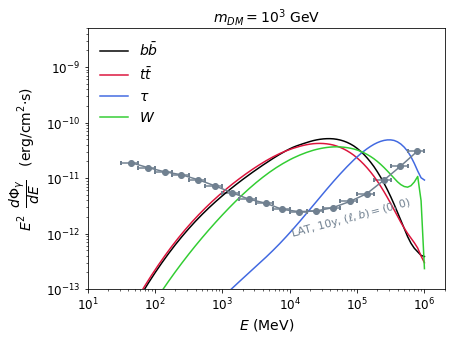

In [26]:
mass = 1e3
for channel, color in zip(channels, colors):
    energy, spectra = query.spectra_at_channel(mass, channel=channel)
    flux = calculate_flux(spectra, mass, j_bar=jbar01, aperture=total_aperture)
    f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
    plt.plot(energy*1e3, (energy**2 * flux), '-', color=color, 
             label=channel)
    
plt.errorbar(x=(emax+emin)/2, y=energy_flux, xerr=(emax-emin)/2, fmt='o-', markersize=6,
            color='slategray', capsize=2, capthick=2)
plt.text(x=1e4, y=0.09e-11, s='LAT, 10y, $(\ell, b) = (0, 0)$',
         fontsize=11, color='slategray', rotation=15)
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
plt.title('$m_{DM} = %s$ GeV'%f._formatSciNotation('%1.10e'%mass), fontsize=14)
ax = plt.gca()
ax.set_xlabel("$E$ (MeV)")
ax.set_ylabel(r"$E^2 \,\,\, \dfrac{d\Phi_{\gamma}}{dE}$ $\,\,$ (erg/cm$^2$$\cdot$s)")
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-13, 5e-9)
plt.xlim(1e1, 2e6)
plt.legend(loc=2, frameon=False)
plt.savefig('../figures/fluxes_diff_sens_comp.pdf', bbox_inches='tight')
plt.show()

* Flux wasn't convolved with the PSF, so that we need to rescale the flux to properly shown it on the same scale of the LAT curve. Try to do it and show it is possible to detect signal in the wanted dark matter particle region! Use gammapy to properly match the scales.